# Import libraries and load data

In [65]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

In [66]:
# load readme file for a quick overview
f = open(os.getenv('HOME')+'/aiffel/yoochoose/data/README', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

SUMMARY




These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 

made by 6,040 MovieLens users who joined MovieLens in 2000.



USAGE LICENSE




Neither the University of Minnesota nor any of the researchers

involved can guarantee the correctness of the data, its suitability

for any particular purpose, or the validity of results based on the

use of the data set.  The data set may be used for any research

purposes under the following conditions:



     * The user may not state or imply any endorsement from the

       University of Minnesota or the GroupLens Research Group.



     * The user must acknowledge the use of the data set in

       publications resulting from the use of the data set

       (see below for citation information).



     * The user may not redistribute the data without separate

       permission.



     * The user may not use this information for any commercial or

       revenue-bearing purposes without first obtaining permi

In [67]:
# load data
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::',
                       header=None, usecols=[0, 1, 2, 3],
                       dtype={0: np.int32, 1: np.int32, 2: np.int32},
                       nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time'] # rename cols
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # sort data by userid and time
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


In [69]:
# convert unix time into datetime
# reference: https://stackoverflow.com/questions/19231871/convert-unix-time-to-readable-date-in-pandas-dataframe

data['Time'] = pd.to_datetime(data['Time'], unit='s')
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


In [70]:
# building rec sys requires checking unique num of userid and itemid

data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [71]:
# check num of clicks of each user

user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [72]:
# stats of user_length
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [73]:
# stats of user_length
user_length.min(), user_length.max()

(20, 2314)

In [74]:
user_length.quantile(0.999)

1343.181000000005

In [75]:
# check the user with odd length
long_session = user_length[user_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-15 20:52:27
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00
695945,4169,1804,2,2002-06-15 21:16:23


In [76]:
# cumsum of user length upto 99.9%
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

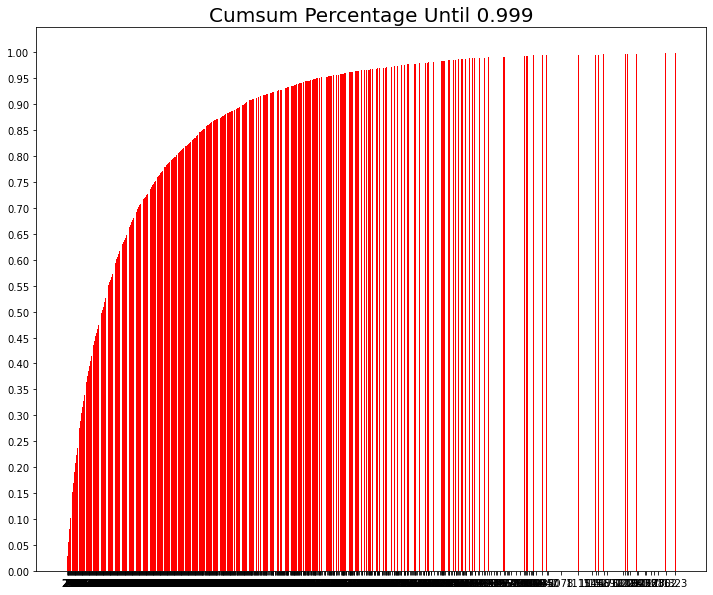

In [77]:
# visualize user_length cumsum
plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [78]:
# check data time stats
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [79]:
# use timedelta when wanting to find the difference between time
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [80]:
# 3 years of data, but when wanting to use only the last month
month_ago = latest - dt.timedelta(30)     # 30 days from maximum time
data = data[data['Time'] > month_ago]     # filter/mask that's in range of last month ~ maximum time
data

,UserId,ItemId,Rating,Time
28225,195,2808,3,2003-02-02 21:08:38
27759,195,1254,4,2003-02-06 17:23:42
27921,195,1456,2,2003-02-08 00:07:32
28443,195,468,3,2003-02-11 17:42:36
28255,195,2748,1,2003-02-11 18:23:28
...,...,...,...,...
984731,5950,3948,4,2003-02-27 18:13:57
984682,5950,3578,4,2003-02-27 18:14:30
984475,5950,3793,3,2003-02-27 18:15:10
984660,5950,3555,2,2003-02-27 18:15:37


In [81]:
# remove when the user had only 1 click as it could be the bizarre item
# remove short_session and remove unpopular item could result in session with only 1
# use while loop to continously remove short_session that's 1 and unpopular item that's 1
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [82]:
# mean value of total userid and item id
data.groupby('UserId').size().mean(), data.groupby('ItemId').size().mean()

(15.058252427184467, 1.5386904761904763)

In [83]:
# clease data
data = cleanse_recursive(data, shortest=4, least_click=2)
data.sort_values(by=['Time'], inplace=True)
data

,UserId,ItemId,Rating,Time
891545,5387,1189,4,2003-01-30 15:50:01
891980,5387,162,3,2003-01-30 15:50:01
891478,5387,246,5,2003-01-30 15:50:15
891346,5387,581,5,2003-01-30 15:50:51
891860,5387,2677,3,2003-01-30 15:51:08
...,...,...,...,...
984660,5950,3555,2,2003-02-27 18:15:37
984733,5950,1262,4,2003-02-27 18:17:38
879288,5312,3267,4,2003-02-28 15:05:11
825526,4958,3489,4,2003-02-28 17:45:20


In [84]:
# train/valid/test splits in session-based recommendation by date
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_in_train = data[data['Time'] < final_time - dt.timedelta(n_days)]
    user_in_test = data[data['Time'] >= final_time - dt.timedelta(n_days)]

    before_date = user_in_train
    after_date = user_in_test
    
    return before_date, after_date

In [85]:
# split last 6 months of data as test from total data and 6 months of data as valid from train data
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [86]:
# quick overview of data after splitting
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [87]:
# stats of each datasets
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 705
	 Users: 30
	 Items: 299
	 First Time : 2003-01-30 15:50:01
	 Last Time : 2003-02-26 16:18:03

* valid Set Stats Info
	 Events: 12
	 Users: 4
	 Items: 12
	 First Time : 2003-02-27 04:40:36
	 Last Time : 2003-02-27 17:45:48

* test Set Stats Info
	 Events: 26
	 Users: 3
	 Items: 26
	 First Time : 2003-02-27 17:50:41
	 Last Time : 2003-02-28 17:49:50



In [88]:
# create index based on train set
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # if item not in id2idx replace as -1
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [89]:
# pickle data
save_path = data_path / 'processed' # Path(os.getenv('HOME')+'/aiffel/yoochoose/data') 
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [90]:
# when given data, find the idx of session starting point and newly indexed value of the session by creating class
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each user IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        # group & sort the df by session_key and get the offset values
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [91]:
# click_offsets instance has idx of each session starting location
# session_idx instance has np.array of each session's index in range

tr_dataset = SessionDataset(tr)
tr_dataset.df

,UserId,ItemId,Rating,Time,item_idx
891545,5387,1189,4,2003-01-30 15:50:01,0
891980,5387,162,3,2003-01-30 15:50:01,1
891478,5387,246,5,2003-01-30 15:50:15,2
891346,5387,581,5,2003-01-30 15:50:51,3
891860,5387,2677,3,2003-01-30 15:51:08,4
...,...,...,...,...,...
261289,1597,2010,4,2003-02-26 16:13:30,291
261146,1597,203,1,2003-02-26 16:15:09,266
261141,1597,1660,5,2003-02-26 16:17:19,283
261142,1597,3418,2,2003-02-26 16:17:34,289


In [92]:
print(len(tr_dataset.click_offsets))
tr_dataset.click_offsets

31


array([  0,  10,  14,  24, 137, 185, 192, 226, 230, 240, 244, 248, 256,
       262, 270, 371, 444, 448, 452, 467, 475, 484, 495, 551, 583, 585,
       597, 611, 647, 652, 705], dtype=int32)

In [93]:
print(len(tr_dataset.session_idx))
tr_dataset.session_idx

30


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [94]:
# class that receives SessionDataset and creates Session-Parallel mini-batch
# __iter__ method yields model input, label, and index of session ending point/location
# mask is used when initializing RNN Cell State

class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # check initialize method
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # receive session idx of first batch
        last_session = self.batch_size - 1    # save last of idx of session index
        # bring begining location of the session in data
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]
        # bring next location right after ending location of the  session in data
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]
        mask = np.array([])       # add mask when session has gone through all the items
        finished = False         # status to check whether all data has been gone through
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # update next batch data
        
        start += min_len   # in __iter__ for loop's been looped by the amount of min_len, so add min_len to start
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end is the loc of next session, if the diff between end and start is 1, then the session is over. Record it in mask

        for i, idx in enumerate(mask, start=1):  # run new session as much as the num of session added to the mask
            new_session = last_session + i  
            # if the new session is bigger than the last session idx, it means model has gone through all trian data
            if new_session > self.dataset.session_idx[-1]:  
                finished = True
                break
            # update the next starting/ending point of the new session
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]
        
        last_session += len(mask)  # record last loc of new session
        
        return start, end, mask, last_session, finished

In [95]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head()

,UserId,ItemId,Rating,Time,item_idx
891545,5387,1189,4,2003-01-30 15:50:01,0
891980,5387,162,3,2003-01-30 15:50:01,1
891478,5387,246,5,2003-01-30 15:50:15,2
891346,5387,581,5,2003-01-30 15:50:51,3
891860,5387,2677,3,2003-01-30 15:51:08,4


In [96]:
iter_ex = iter(tr_data_loader)

In [97]:
# iteration/generator
# check input, output, mask

inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 10 14 24]
Label Item Idx are :       [ 1 11 15 25]
Previous Masked Input Idx are []


In [98]:
# in Session-Based Recommendation Task, model's performance is measured when the model represents k items matches user's n items/clicks
# hence use recall@k or mean avereage precision @k
# also important the order of the k items
# so metrics like MRR, NDCG are also used
# MRR: inverse num of correct item order
# correct item is in the front of the k items, evaluation goes up, if it's in the rear, evaluation goes down
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [99]:
# create Functional API
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [100]:
# model hyper parameters
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_users = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=2, k=20) # change bs from 2048 > 256 when training

In [101]:
# train and validate
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # reset hidden_state

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # validate using valid set

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # gru layer from the model
    hidden_states = gru_layer.states[0].numpy()  # bring parameter from gru_layer
    for elt in mask:  # masekd idx, go through ended session's idx
        hidden_states[elt, :] = 0  # and reset parameter
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # evaluate valid set and test set
                                             # similar to train has a code to compute mrr, recall
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)
        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING') # sort in order of big to small vals of softmax
        
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    
    return recall, mrr

In [102]:
# define evaluation model metrics
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

# Model 1

- no change

In [39]:
# assign and set up a model
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3592)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    546600    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3592)               183192    
Total params: 729,792
Trainable params: 729,792
Non-trainable params: 0
_________________________________________________________________


Evaluation:  15%|█▌        | 7/46 [00:08<00:45,  1.17s/it]


	 - Recall@20 epoch 1: 0.043527
	 - MRR@20    epoch 1: 0.007768



Evaluation:  15%|█▌        | 7/46 [00:07<00:43,  1.12s/it]


	 - Recall@20 epoch 2: 0.065848
	 - MRR@20    epoch 2: 0.015740



Evaluation:  15%|█▌        | 7/46 [00:07<00:43,  1.11s/it]


	 - Recall@20 epoch 3: 0.078125
	 - MRR@20    epoch 3: 0.015755



Evaluation:  15%|█▌        | 7/46 [00:07<00:42,  1.10s/it]


	 - Recall@20 epoch 4: 0.080357
	 - MRR@20    epoch 4: 0.017551



Evaluation:  15%|█▌        | 7/46 [00:07<00:42,  1.10s/it]

	 - Recall@20 epoch 5: 0.083147
	 - MRR@20    epoch 5: 0.018767



In [40]:
test_model(model, args, test)

Evaluation:   6%|▌         | 2/33 [00:02<00:34,  1.10s/it]

	 - Recall@20: 0.089844
	 - MRR@20: 0.022665



# Model 2

- match hyperparameter (bs & hsz)

In [41]:
# assign and set up a model
args = Args(tr, val, test, batch_size=256, hsz=256, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(256, 1, 3592)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 256), (256, 256)]  2956800   
_________________________________________________________________
dropout_1 (Dropout)          (256, 256)                0         
_________________________________________________________________
dense_1 (Dense)              (256, 3592)               923144    
Total params: 3,879,944
Trainable params: 3,879,944
Non-trainable params: 0
_________________________________________________________________


Evaluation:  15%|█▌        | 7/46 [00:08<00:46,  1.18s/it]


	 - Recall@20 epoch 1: 0.070312
	 - MRR@20    epoch 1: 0.019325



Evaluation:  15%|█▌        | 7/46 [00:07<00:43,  1.12s/it]


	 - Recall@20 epoch 2: 0.079799
	 - MRR@20    epoch 2: 0.020900



Evaluation:  15%|█▌        | 7/46 [00:07<00:43,  1.12s/it]


	 - Recall@20 epoch 3: 0.092076
	 - MRR@20    epoch 3: 0.023711



Evaluation:  15%|█▌        | 7/46 [00:07<00:44,  1.14s/it]


	 - Recall@20 epoch 4: 0.089286
	 - MRR@20    epoch 4: 0.022849



Evaluation:  15%|█▌        | 7/46 [00:07<00:44,  1.13s/it]

	 - Recall@20 epoch 5: 0.087612
	 - MRR@20    epoch 5: 0.022858



In [42]:
test_model(model, args, test)

Evaluation:   6%|▌         | 2/33 [00:02<00:34,  1.12s/it]

	 - Recall@20: 0.078125
	 - MRR@20: 0.017731



# Model 3

- update hp to a lower level (bs & hsz)

In [43]:
# assign and set up a model
args = Args(tr, val, test, batch_size=128, hsz=128, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3592)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 128), (128, 128)]  1429248   
_________________________________________________________________
dropout_2 (Dropout)          (128, 128)                0         
_________________________________________________________________
dense_2 (Dense)              (128, 3592)               463368    
Total params: 1,892,616
Trainable params: 1,892,616
Non-trainable params: 0
_________________________________________________________________


Evaluation:  45%|████▍     | 41/92 [00:24<00:30,  1.70it/s]


	 - Recall@20 epoch 1: 0.093750
	 - MRR@20    epoch 1: 0.019803



Evaluation:  45%|████▍     | 41/92 [00:23<00:29,  1.75it/s]


	 - Recall@20 epoch 2: 0.101944
	 - MRR@20    epoch 2: 0.023405



Evaluation:  45%|████▍     | 41/92 [00:23<00:29,  1.73it/s]


	 - Recall@20 epoch 3: 0.106707
	 - MRR@20    epoch 3: 0.026733



Evaluation:  45%|████▍     | 41/92 [00:23<00:29,  1.73it/s]


	 - Recall@20 epoch 4: 0.109756
	 - MRR@20    epoch 4: 0.027657



Evaluation:  45%|████▍     | 41/92 [00:23<00:29,  1.74it/s]

	 - Recall@20 epoch 5: 0.109375
	 - MRR@20    epoch 5: 0.028473



In [44]:
test_model(model, args, test)

Evaluation:  36%|███▋      | 24/66 [00:13<00:23,  1.78it/s]

	 - Recall@20: 0.126302
	 - MRR@20: 0.034780



# Model 4

- update hp to a lower level (bs & hsz)

In [45]:
# assign and set up a model
args = Args(tr, val, test, batch_size=64, hsz=64, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 1, 3592)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 64), (64, 64)]      702336    
_________________________________________________________________
dropout_3 (Dropout)          (64, 64)                  0         
_________________________________________________________________
dense_3 (Dense)              (64, 3592)                233480    
Total params: 935,816
Trainable params: 935,816
Non-trainable params: 0
_________________________________________________________________


Evaluation:  67%|██████▋   | 124/185 [00:38<00:18,  3.26it/s]


	 - Recall@20 epoch 1: 0.104965
	 - MRR@20    epoch 1: 0.022981



Evaluation:  67%|██████▋   | 124/185 [00:37<00:18,  3.35it/s]


	 - Recall@20 epoch 2: 0.118700
	 - MRR@20    epoch 2: 0.027241



Evaluation:  67%|██████▋   | 124/185 [00:37<00:18,  3.35it/s]


	 - Recall@20 epoch 3: 0.123110
	 - MRR@20    epoch 3: 0.029876



Evaluation:  67%|██████▋   | 124/185 [00:37<00:18,  3.31it/s]


	 - Recall@20 epoch 4: 0.124370
	 - MRR@20    epoch 4: 0.030802



Evaluation:  67%|██████▋   | 124/185 [00:37<00:18,  3.34it/s]

	 - Recall@20 epoch 5: 0.126512
	 - MRR@20    epoch 5: 0.031472



In [46]:
test_model(model, args, test)

Evaluation:  59%|█████▉    | 78/132 [00:23<00:16,  3.31it/s]

	 - Recall@20: 0.138622
	 - MRR@20: 0.034880



# Model 5

- update hp to a lower level (bs & hsz)

In [47]:
# assign and set up a model
args = Args(tr, val, test, batch_size=32, hsz=32, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(32, 1, 3592)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 32), (32, 32)]      348096    
_________________________________________________________________
dropout_4 (Dropout)          (32, 32)                  0         
_________________________________________________________________
dense_4 (Dense)              (32, 3592)                118536    
Total params: 466,632
Trainable params: 466,632
Non-trainable params: 0
_________________________________________________________________


Evaluation:  83%|████████▎ | 307/371 [00:51<00:10,  5.99it/s]


	 - Recall@20 epoch 1: 0.101283
	 - MRR@20    epoch 1: 0.021268



Evaluation:  83%|████████▎ | 307/371 [00:51<00:10,  5.99it/s]


	 - Recall@20 epoch 2: 0.114923
	 - MRR@20    epoch 2: 0.024730



Evaluation:  83%|████████▎ | 307/371 [00:51<00:10,  6.01it/s]


	 - Recall@20 epoch 3: 0.117976
	 - MRR@20    epoch 3: 0.026240



Evaluation:  83%|████████▎ | 307/371 [00:51<00:10,  6.01it/s]


	 - Recall@20 epoch 4: 0.119198
	 - MRR@20    epoch 4: 0.027416



Evaluation:  83%|████████▎ | 307/371 [00:50<00:10,  6.04it/s]

	 - Recall@20 epoch 5: 0.119401
	 - MRR@20    epoch 5: 0.027932



In [48]:
test_model(model, args, test)

Evaluation:  74%|███████▎  | 195/265 [00:32<00:11,  6.07it/s]

	 - Recall@20: 0.130929
	 - MRR@20: 0.030853



# Model 6

- add 1xGRU and 1xdropout layers

In [49]:
# create Functional API
def create_model2(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [50]:
# assign and set up a model
args = Args(tr, val, test, batch_size=256, hsz=256, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model2(args)
train_model(model, args)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(256, 1, 3592)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 256), (256, 256)]  2956800   
_________________________________________________________________
dropout_6 (Dropout)          (256, 256)                0         
_________________________________________________________________
dense_5 (Dense)              (256, 3592)               923144    
Total params: 3,879,944
Trainable params: 3,879,944
Non-trainable params: 0
_________________________________________________________________


Evaluation:  15%|█▌        | 7/46 [00:07<00:44,  1.14s/it]


	 - Recall@20 epoch 1: 0.073103
	 - MRR@20    epoch 1: 0.016290



Evaluation:  15%|█▌        | 7/46 [00:07<00:44,  1.13s/it]


	 - Recall@20 epoch 2: 0.082031
	 - MRR@20    epoch 2: 0.019532



Evaluation:  15%|█▌        | 7/46 [00:07<00:42,  1.09s/it]


	 - Recall@20 epoch 3: 0.082031
	 - MRR@20    epoch 3: 0.022463



Evaluation:  15%|█▌        | 7/46 [00:07<00:42,  1.09s/it]


	 - Recall@20 epoch 4: 0.088170
	 - MRR@20    epoch 4: 0.024190



Evaluation:  15%|█▌        | 7/46 [00:07<00:42,  1.09s/it]

	 - Recall@20 epoch 5: 0.089286
	 - MRR@20    epoch 5: 0.022996



In [51]:
test_model(model, args, test)

Evaluation:   6%|▌         | 2/33 [00:02<00:35,  1.14s/it]

	 - Recall@20: 0.078125
	 - MRR@20: 0.019389



# Model 7

- update hp to a lower level (bs & hsz)

In [52]:
# assign and set up a model
args = Args(tr, val, test, batch_size=128, hsz=128, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model2(args)
train_model(model, args)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(128, 1, 3592)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 128), (128, 128)]  1429248   
_________________________________________________________________
dropout_8 (Dropout)          (128, 128)                0         
_________________________________________________________________
dense_6 (Dense)              (128, 3592)               463368    
Total params: 1,892,616
Trainable params: 1,892,616
Non-trainable params: 0
_________________________________________________________________


Evaluation:  45%|████▍     | 41/92 [00:23<00:29,  1.75it/s]


	 - Recall@20 epoch 1: 0.092797
	 - MRR@20    epoch 1: 0.020844



Evaluation:  45%|████▍     | 41/92 [00:23<00:28,  1.78it/s]


	 - Recall@20 epoch 2: 0.104802
	 - MRR@20    epoch 2: 0.025172



Evaluation:  45%|████▍     | 41/92 [00:22<00:28,  1.79it/s]


	 - Recall@20 epoch 3: 0.108613
	 - MRR@20    epoch 3: 0.027552



Evaluation:  45%|████▍     | 41/92 [00:23<00:28,  1.77it/s]


	 - Recall@20 epoch 4: 0.110709
	 - MRR@20    epoch 4: 0.028697



Evaluation:  45%|████▍     | 41/92 [00:23<00:28,  1.76it/s]

	 - Recall@20 epoch 5: 0.112995
	 - MRR@20    epoch 5: 0.029037



In [53]:
test_model(model, args, test)

Evaluation:  36%|███▋      | 24/66 [00:13<00:23,  1.79it/s]

	 - Recall@20: 0.131185
	 - MRR@20: 0.034639



# Model 8

- update hp to a lower level (bs & hsz)

In [54]:
# assign and set up a model
args = Args(tr, val, test, batch_size=64, hsz=64, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model2(args)
train_model(model, args)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(64, 1, 3592)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 64), (64, 64)]      702336    
_________________________________________________________________
dropout_10 (Dropout)         (64, 64)                  0         
_________________________________________________________________
dense_7 (Dense)              (64, 3592)                233480    
Total params: 935,816
Trainable params: 935,816
Non-trainable params: 0
_________________________________________________________________


Evaluation:  67%|██████▋   | 124/185 [00:37<00:18,  3.34it/s]


	 - Recall@20 epoch 1: 0.104461
	 - MRR@20    epoch 1: 0.022570



Evaluation:  67%|██████▋   | 124/185 [00:36<00:18,  3.38it/s]


	 - Recall@20 epoch 2: 0.116557
	 - MRR@20    epoch 2: 0.028398



Evaluation:  67%|██████▋   | 124/185 [00:37<00:18,  3.35it/s]


	 - Recall@20 epoch 3: 0.119330
	 - MRR@20    epoch 3: 0.028808



Evaluation:  67%|██████▋   | 124/185 [00:37<00:18,  3.34it/s]


	 - Recall@20 epoch 4: 0.122354
	 - MRR@20    epoch 4: 0.029563



Evaluation:  67%|██████▋   | 124/185 [00:36<00:18,  3.36it/s]

	 - Recall@20 epoch 5: 0.121850
	 - MRR@20    epoch 5: 0.030376



In [55]:
test_model(model, args, test)

Evaluation:  59%|█████▉    | 78/132 [00:22<00:15,  3.41it/s]

	 - Recall@20: 0.139022
	 - MRR@20: 0.035769



# Model 9

- update hp to a lower level (bs & hsz)

In [56]:
# assign and set up a model
args = Args(tr, val, test, batch_size=32, hsz=32, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model2(args)
train_model(model, args)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(32, 1, 3592)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 32), (32, 32)]      348096    
_________________________________________________________________
dropout_12 (Dropout)         (32, 32)                  0         
_________________________________________________________________
dense_8 (Dense)              (32, 3592)                118536    
Total params: 466,632
Trainable params: 466,632
Non-trainable params: 0
_________________________________________________________________


Evaluation:  83%|████████▎ | 307/371 [00:52<00:10,  5.89it/s]


	 - Recall@20 epoch 1: 0.100265
	 - MRR@20    epoch 1: 0.021232



Evaluation:  83%|████████▎ | 307/371 [00:51<00:10,  5.99it/s]


	 - Recall@20 epoch 2: 0.113599
	 - MRR@20    epoch 2: 0.024513



Evaluation:  83%|████████▎ | 307/371 [00:51<00:10,  5.96it/s]


	 - Recall@20 epoch 3: 0.118485
	 - MRR@20    epoch 3: 0.026581



Evaluation:  83%|████████▎ | 307/371 [00:51<00:10,  6.01it/s]


	 - Recall@20 epoch 4: 0.119300
	 - MRR@20    epoch 4: 0.027635



Evaluation:  83%|████████▎ | 307/371 [00:51<00:10,  6.01it/s]

	 - Recall@20 epoch 5: 0.118893
	 - MRR@20    epoch 5: 0.028092



In [57]:
test_model(model, args, test)

Evaluation:  74%|███████▎  | 195/265 [00:32<00:11,  6.08it/s]

	 - Recall@20: 0.134615
	 - MRR@20: 0.030947



# Model 10

- update session to use only the last month of the given dataset

In [109]:
# assign and set up a model
args = Args(tr, val, test, batch_size=3, hsz=256, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(3, 1, 299)]             0         
_________________________________________________________________
GRU (GRU)                    [(3, 256), (3, 256)]      427776    
_________________________________________________________________
dropout_20 (Dropout)         (3, 256)                  0         
_________________________________________________________________
dense_16 (Dense)             (3, 299)                  76843     
Total params: 504,619
Trainable params: 504,619
Non-trainable params: 0
_________________________________________________________________


Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]


	 - Recall@20 epoch 1: nan
	 - MRR@20    epoch 1: nan



Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]


	 - Recall@20 epoch 2: nan
	 - MRR@20    epoch 2: nan



Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]


	 - Recall@20 epoch 3: nan
	 - MRR@20    epoch 3: nan



Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]


	 - Recall@20 epoch 4: nan
	 - MRR@20    epoch 4: nan



Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

	 - Recall@20 epoch 5: nan
	 - MRR@20    epoch 5: nan



In [110]:
test_model(model, args, test)

Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

	 - Recall@20: nan
	 - MRR@20: nan



# 회고

1회차
- 모델 구현을 위한 코딩 작업을 하다가 모델 학습 구간에서 IndexError가 계속 났다.
    - IndexError: index 6 is out of bounds for axis 0 with size 6

2회차
- 계속 같은 에러가 나서 try-except를 추가해 주었다.
    - 추가해 주었더니, UnboundLocalError: local variable 'start' referenced before assignment가 났다.
    - try-except로도 해결이 안되서 start와 end에 프린트문 코드를 추가해서 직접 보기로 했다.
- 에러가 나는 지점이 validation 데이터셋을 다룰때 user수에 비례해 에러가 난다는 것을 알게 되었다.
    - 문제를 해결하는 방법이 떠오르지 않았다.
    
3회차
- 코드를 한줄 한줄 살펴보다가 데이터셋을 학습, 검증, 테스트에서 나눈 시점에서 내가 지정한 모델의 batch_size보다 검증, 테스트의 batch_size가 현저히 작아서 IndexError가 나는 것을 깨달았고 문제를 해결했다.
- 결국엔 해결을 하여 원본 모델 이외에 3가지 다른 방식으로 실험을 진행했다.
- 1번째 방법: hp를 바꾼다
    - hp를 줄이면 줄일수록 결과가 좋아졌다
    - Recall은 최대 13% 나왔고 MRR은 3%
- 2번째 방법: 모델 구현을 바꾼다 (layer 추가)
    - 1번째 방법이랑 결과가 크게 다르지는 않았다.
    - hp를 줄이며 결과가 올라가는 경향을 보였다.
- 3번째 방법: 총 3년 데이터 중 마지막 한달만 사용한다
    - NaN값이 나왔다.
    - 데이터가 많이 적어서 학습이 안되는걸로 추정이 된다.